In [132]:
from IPython.display import Image, display
import pandas as pd
import json
from functools import lru_cache
from dotenv import load_dotenv
import re
from rapidfuzz import process, fuzz
import yfinance as yf

from langchain_openai import ChatOpenAI
from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage, HumanMessage, AnyMessage
from langchain_core.messages import RemoveMessage
from langchain_core.prompts import ChatPromptTemplate

from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from langgraph.graph.message import REMOVE_ALL_MESSAGES
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

from typing import TypedDict, Literal, Optional, List, Dict, Union
from typing_extensions import Annotated
from operator import add

In [133]:
# Load env variables from .env.example
load_dotenv("../.env")

True

In [ ]:
# initialize model for large number of input tokens
llmg = init_chat_model("gemini-2.0-flash-lite", model_provider="google_genai")

In [135]:
# Load CSV of NSE companies
df = pd.read_csv("../data/EQUITY_L.csv")
company_names = df["NAME OF COMPANY"].tolist()

In [136]:
# Custom reducer function for merging dictionaries
def merge_dicts(current: Dict, update: Dict) -> Dict:
    """
    Merge two dictionaries, with update taking precedence for overlapping keys.
    You can customize this logic (e.g., deep merge, append to lists, etc.).
    """
    new_dict = current.copy()  # Create a copy to avoid mutating the original
    new_dict.update(update)    # Merge update into current
    return new_dict

In [137]:
class GraphState(MessagesState):
    query_type: Literal["new", "follow_up", "other"]
    symbol: str = None       # Stock symbol, e.g., 'HDFCBANK'
    news_required: bool = False
    data: Annotated[Dict, merge_dicts]  # merge dict updates
    response: str = None     # Model's textual reply

In [138]:
prompt_classify_input_query = ChatPromptTemplate.from_template(
    "You are a query classifier for a stock analysis app.\n"
    "You will be given a list of user messages. Focus on the **last message** in context of the conversation.\n\n"
    "Classify the last message into exactly one of these categories:\n"
    "1. 'new' — The last message is about **exactly one specific stock or company**, either by:\n"
    "   - Explicit company name (e.g., 'Tata Motors', 'Infosys'),\n"
    "   - Common abbreviation or short name (e.g., 'SBI' for State Bank of India),\n"
    "   - A valid stock ticker (e.g., 'HDFCBANK', 'RELIANCE').\n"
    "   The stock should not have been mentioned in the previous messages.\n\n"
    "2. 'follow_up' — The last message refers to the **same stock already discussed earlier** without explicitly naming it, "
    "or uses terms like 'it', 'that stock', 'this company', 'the bank', 'the one we talked about'.\n\n"
    "3. 'other' — The last message is unrelated to stocks, mentions multiple stocks, or is about general market trends, sectors, or industries.\n\n"
    "Important:\n"
    "- Treat **abbreviations, acronyms, and tickers** as valid company mentions.\n"
    "- Always pick only one label.\n"
    "- Return only the label text ('new', 'follow_up', or 'other'), nothing else.\n\n"
    "Conversation messages: {messages}\n"
    "Last message to classify: {messages}[-1]"
)


In [139]:
def classify_query(state: GraphState) -> dict:
    chain = prompt_classify_input_query | llmg
    result = chain.invoke({"messages": state["messages"]}).content.strip()

    if result == "new":
        return {"messages": [RemoveMessage(id=m.id) for m in state["messages"][:-1]],
                "query_type": "new",
                "symbol": None,
                "data": {}
               }
    elif result == "follow_up":
        return {"query_type": "follow_up"}
    else:
        return {"query_type": "other"}

In [140]:
def handle_follow_up_query(state: GraphState):
    # for future use
    return

In [141]:
def route_query(state: GraphState) -> Literal["new", "follow_up", "other"]:
    return state["query_type"]

In [142]:
# Prompt to extract company name
prompt_extract_symbol = ChatPromptTemplate.from_template(
    "Extract only the company or stock name from the user's stock-related messages. "
    "Respond with the extracted company name from the query as a single string. "
    "messages: {messages}"
)

prompt_disambiguate = ChatPromptTemplate.from_template("""
You are a financial assistant that helps identify the correct Indian company 
from a user's query.

The user has asked about this stock or company: "{user_query}"

Here are the possible company matches from our database:
{candidates}

Your task:
- Pick the single most likely company name from the candidates that matches the user's intent.
- If none of the candidates are a good match, output "NO_MATCH".
- Do NOT explain your reasoning, just output the company name (or "NO_MATCH").

Answer strictly with only one of:
1. A company name from the candidates list, OR
2. "NO_MATCH"
""")


In [143]:
def normalize(text: str) -> str:
    text = text.lower().strip()
    text = re.sub(r'[^a-z0-9\s]', '', text)  # remove punctuation
    text = re.sub(r'\b(ltd|limited|inc|corp|company|co)\b', '', text)  # remove suffixes
    return re.sub(r'\s+', ' ', text).strip()

def extract_symbol(state: GraphState) -> dict:
    query = state["messages"][-1]  # user query
    chain = prompt_extract_symbol | llmg
    extracted_name = chain.invoke({"messages": state["messages"]}).content.strip()

    # Normalize
    extracted_norm = normalize(extracted_name)

    # Try direct symbol match first
    if extracted_norm.upper() in df["SYMBOL"].values:
        return {"symbol": extracted_norm.upper()}

    # Exact match on company name
    for name in df["NAME OF COMPANY"].values:
        if normalize(name) == extracted_norm:
            symbol = df[df["NAME OF COMPANY"] == name]["SYMBOL"].values[0]
            return {"symbol": symbol}

    # Fuzzy match (RapidFuzz)
    matches = process.extract(
        extracted_norm, 
        [normalize(n) for n in company_names], 
        scorer=fuzz.token_sort_ratio,
        limit=3
    )

    best_match, best_score, idx = matches[0]

    if best_score >= 90:  # high confidence
        symbol = df.iloc[idx]["SYMBOL"]
        return {"symbol": symbol}

    elif best_score >= 75:  # medium confidence → ask LLM
        candidates = [df.iloc[m[2]]["NAME OF COMPANY"] for m in matches]
        disambig_chain = prompt_disambiguate | llmg
        final_choice = disambig_chain.invoke({"user_query": extracted_name, "candidates": candidates})
        # pick symbol of chosen company
        chosen = final_choice.content.strip()
        symbol = df[df["NAME OF COMPANY"] == chosen]["SYMBOL"].values[0]
        return {"symbol": symbol}

    return {"symbol": "NO_MATCH"}

In [144]:
# Cache important keys CSV so it’s loaded only once
@lru_cache(maxsize=1)
def load_keys_to_keep(csv_path="../important_keys.csv"):
    try:
        keys_df = pd.read_csv(csv_path, header=None)
        return set(keys_df.iloc[0].dropna().tolist())
    except Exception:
        return set()

In [145]:
def get_stock_info(state: GraphState) -> dict:
    # Handle missing/invalid symbol
    if state.get("symbol") == "NO_MATCH":
        return {"data": {"stock_info": "No data available for this stock."}}

    stock_symbol = state["symbol"]
    try:
        stock = yf.Ticker(f"{stock_symbol}.NS")
    except Exception:
        return {"data": {"stock_info": "No data available for this stock."}}

     # Handle new queries → fetch structured stock info
    try:
        keys_to_keep = load_keys_to_keep()
        info = stock.info
        filtered_info = {k: v for k, v in info.items() if k in keys_to_keep}
    except Exception:
        filtered_info = {"data": {"stock_info": "No data available for this stock."}}

    return {"data": {"stock_info": filtered_info}}

In [146]:
def get_stock_news(state: GraphState) -> dict:
    news_string = ""
    stock_symbol = state["symbol"]
    try:
        stock = yf.Ticker(f"{stock_symbol}.NS")
        news = stock.get_news(count=3)
        for article in news:
            news_string += f"Publication Date: {article['content']['pubDate'][:10]}\nsummary:  {article['content']['summary']}\n"
    except Exception as e:
        print(f"error getting news: {e}")
    return {"data": {"stock_news": news_string}}

In [147]:
prompt_handle_other = ChatPromptTemplate.from_template(
    "You are a polite assistant for a stock analysis app.\n"
    "You will be given a user message.\n\n"
    "Rules:\n"
    "1. If it is a simple greeting (hello, hi, good morning, how are you, etc.):\n"
    "   - Greet back warmly.\n"
    "2. For any other message:\n"
    "   - Politely explain that this app can only help with single stock analysis and cannot answer other types of questions.\n\n"
    "message: {messages}"
)
# Refined prompt to answer user messages
prompt_answer_query = ChatPromptTemplate.from_template(
    "You are a professional financial analyst tasked with answering user queries.\n\n"
    "You are provided with structured stock-related data for a company:\n"
    "{stock_parameters}\n\n"
    "You are also provided with recent news excerpts related to this company or stock:\n"
    "{news_data}\n\n"
    "User query:\n"
    "{messages}\n\n"
    "Guidelines for your response:\n"
    "- Base your answer strictly on the provided stock parameters and news excerpts.\n"
    "- Use news excerpts only if they add meaningful context or insights; Do not include irrelevant details.\n"
    "- Provide a clear, accurate, and professional explanation in concise language (max 300–350 words).\n"
    "- If the available data is insufficient to fully answer the query, explicitly state the limitation.\n"
    "- Do not use external knowledge, speculation, or assumptions.\n\n"
    "Your response should be factual, structured, and precise, resembling the tone of a financial report."
)


In [148]:
def answer_query(state: GraphState) -> dict:
    if state.get("query_type") == "other":
        chain = prompt_handle_other | llmg
        result = chain.invoke({"messages": state["messages"][-1]})
        return {"response": result}
    # define the llm chain
    chain = prompt_answer_query | llmg
    # get stock parameters
    if state["data"]["stock_info"]: 
        formatted_info = json.dumps(state["data"]["stock_info"], indent=2)
    else:
        formatted_info = "No stock info available!"
    # Get news data    
    if state["data"]["stock_news"]:
        news_info = state["data"]["stock_news"]
    else:
        news_info = "Sorry. No news data available!!"
    result = chain.invoke({
            "messages": state["messages"][-1],
            "stock_parameters": formatted_info,
            "news_data": news_info
        })
    return {"response": result}

In [149]:
# Build the graph
workflow = StateGraph(GraphState)

workflow.add_node("classify_query", classify_query)
workflow.add_node("handle_follow_up_query", handle_follow_up_query)
workflow.add_node("extract_symbol", extract_symbol)
workflow.add_node("get_stock_info", get_stock_info)
workflow.add_node("get_stock_news", get_stock_news)
workflow.add_node("answer_query", answer_query)

workflow.add_edge(START, "classify_query")
workflow.add_conditional_edges(
    "classify_query",
    route_query,
    {
        "new": "extract_symbol",
        "follow_up": "handle_follow_up_query",
        "other": "answer_query"
    }
)
workflow.add_edge("extract_symbol", "get_stock_info")
workflow.add_edge("extract_symbol", "get_stock_news")
workflow.add_edge("get_stock_info", "answer_query")
workflow.add_edge("get_stock_news", "answer_query")
workflow.add_edge("handle_follow_up_query", "answer_query")
workflow.add_edge("answer_query", END)

In [150]:
# Configure memory
checkpointer = MemorySaver()
# Compile the graph with checkpointer
app = workflow.compile(checkpointer=checkpointer)

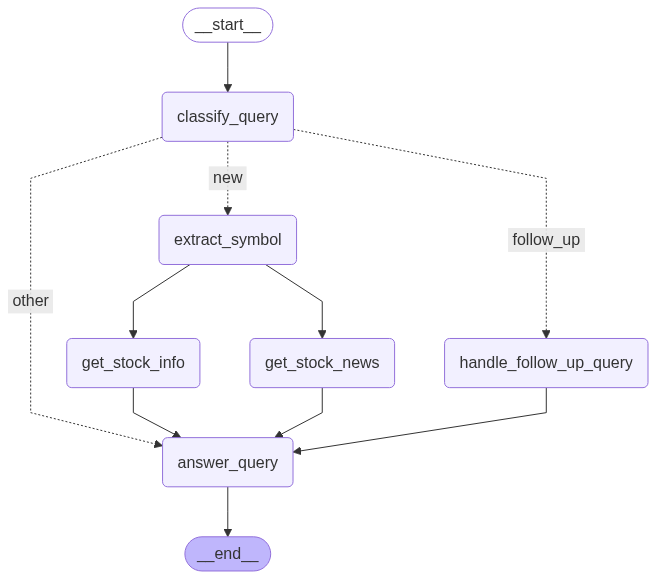

In [151]:
# View
display(Image(app.get_graph().draw_mermaid_png()))

In [154]:
config = {"configurable": {"thread_id": "test_1"}}
node_to_stream = 'answer_query'
input_message = HumanMessage(content=input())
async for event in app.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="")

 give me current price of tcs.


The current price of Tata Consultancy Services (TCS.NS) is 3014.0 INR.

Based on recent news, TCS is navigating a complex environment. While the company announced salary increases for 80% of its workforce, it also implemented layoffs affecting over 12,000 employees. TCS attributed these layoffs to skill mismatches, but industry experts suggest this could be the start of a broader trend of AI-fueled job eliminations within the Indian IT sector. This context provides a more nuanced view of the company's current situation, beyond just the stock price.
